In [ ]:
#necessary import:
import pandas as pd
import time

In [ ]:
#SLOW VERSION WITH CSV
#Loading the two datasets. So far we'll only be using the BPI.csv one
#This also parses the date column
df = pd.read_csv('DBL 2012/BPI.csv', parse_dates=['time:timestamp'])
df_attr = pd.read_csv('DBL 2012/BPI_attr.csv')

In [ ]:
#In case you have no HDF file yet, run this
df.to_hdf('BPI.h5', key='data', mode='w')
df_attr.to_hdf('BPI_attr.h5', key='data', mode='w')

In [ ]:
#FAST VERSION WITH HDF
#Loading the two datasets. So far we'll only be using the BPI.h5 one
df = pd.read_hdf('BPI.csv')
df_attr = pd.read_hdf('BPI_attr.h5')

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 1,org:resource,lifecycle:transition,concept:name,time:timestamp
0,0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00
1,0,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00
2,0,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00
3,0,3,112.0,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00
4,0,4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00


Unnamed 0 is the number of the case, Unnamed 1 is the number of the step for that case

In [ ]:
#Let us change the column names to the aforementioned
df.columns = ['case_id', 'step_number', 'org:resource', 'lifecycle:transition',
       'concept:name', 'time:timestamp']

In [ ]:
df.head(10) #here let's a look at the df after some really basic pre-processing

,case_id,step_number,org:resource,lifecycle:transition,concept:name,time:timestamp
0,0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00
1,0,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00
2,0,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00
3,0,3,112.0,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00
4,0,4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00
5,0,5,10862.0,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00
6,0,6,10862.0,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+02:00
7,0,7,10862.0,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+02:00
8,0,8,10862.0,COMPLETE,O_CREATED,2011-10-01 11:45:11.197000+02:00
9,0,9,10862.0,COMPLETE,O_SENT,2011-10-01 11:45:11.380000+02:00


Creating a smaller df to test functions on:

In [ ]:
#Erasing all the non-complete actions from the database:
df = df[df['lifecycle:transition'] == 'COMPLETE']

In [ ]:
df = df.reset_index()

In [ ]:
#I used to suppress the output of the cell, but didn't know it also does not save any progress within this cell
#So in order for df to update globally, we can't suppress the output unfortunately
df.drop('index', axis=1)

,case_id,step_number,org:resource,lifecycle:transition,concept:name,time:timestamp
0,0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00
1,0,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00
2,0,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00
3,0,5,10862.0,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00
4,0,6,10862.0,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+02:00
...,...,...,...,...,...,...
164501,13085,16,11119.0,COMPLETE,W_Nabellen offertes,2012-03-10 12:50:54.881000+01:00
164502,13086,0,112.0,COMPLETE,A_SUBMITTED,2012-02-29 23:51:16.799000+01:00
164503,13086,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+01:00
164504,13086,4,11169.0,COMPLETE,A_DECLINED,2012-03-01 09:27:37.118000+01:00


In [ ]:
#Set the time difference column
#This function is places here because of the erased non-complete actions
df['time:time_between'] = df['time:timestamp'].diff()
df.loc[df['step_number'] == 0, 'time:time_between'] = pd.Timedelta(0)
df.head(10)

,index,case_id,step_number,org:resource,lifecycle:transition,concept:name,time:timestamp,time:time_between
0,0,0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,0 days 00:00:00
1,1,0,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,0 days 00:00:00.334000
2,2,0,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,0 days 00:00:53.026000
3,5,0,5,10862.0,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,0 days 11:03:05.402000
4,6,0,6,10862.0,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+02:00,0 days 00:02:25.935000
5,7,0,7,10862.0,COMPLETE,A_FINALIZED,2011-10-01 11:45:09.243000+02:00,0 days 00:00:00
6,8,0,8,10862.0,COMPLETE,O_CREATED,2011-10-01 11:45:11.197000+02:00,0 days 00:00:01.954000
7,9,0,9,10862.0,COMPLETE,O_SENT,2011-10-01 11:45:11.380000+02:00,0 days 00:00:00.183000
8,11,0,11,NaN,COMPLETE,W_Completeren aanvraag,2011-10-01 11:45:13.917000+02:00,0 days 00:00:02.537000
9,13,0,13,NaN,COMPLETE,W_Nabellen offertes,2011-10-01 12:17:08.924000+02:00,0 days 00:31:55.007000


In [ ]:
# 0:Monday,..., 6:Sunday
df['time:weekday'] = [x.weekday() for x in df['time:timestamp']]
df['time:hour'] = [x.hour for x in df['time:timestamp']]
df.head()

,index,case_id,step_number,org:resource,lifecycle:transition,concept:name,time:timestamp,time:time_between,time:weekday,time:hour
0,0,0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,0 days 00:00:00,5,0
1,1,0,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,0 days 00:00:00.334000,5,0
2,2,0,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,0 days 00:00:53.026000,5,0
3,5,0,5,10862.0,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,0 days 11:03:05.402000,5,11
4,6,0,6,10862.0,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+02:00,0 days 00:02:25.935000,5,11


In [ ]:
df['concept:name'][15:30]

15                O_ACCEPTED
16               A_ACTIVATED
17      W_Valideren aanvraag
18               A_SUBMITTED
19         A_PARTLYSUBMITTED
20             A_PREACCEPTED
21    W_Completeren aanvraag
22                A_ACCEPTED
23               A_FINALIZED
24                O_SELECTED
25                 O_CREATED
26                    O_SENT
27    W_Completeren aanvraag
28       W_Nabellen offertes
29                O_SELECTED
Name: concept:name, dtype: object

The baseline functions:

In [ ]:
def creating_dict_for_next_step_stats (df : pd.DataFrame, concept_name : str) -> dict:
    '''For an input action checks for all the possible next actions and counts their occurence'''
    
    dic_occurrence = {}
    dic_total_time = {}
    ids = list(df['case_id']) + ['editor: last id'] #Otherwise we check i+1-th position that does not exist
    times = list(df['time:time_between']) + [pd.Timedelta(0)] #Otherwise we check i+1-th position that does not exist
    names = df['concept:name']
    df_concept = df[names == concept_name]
    
    for i, row in df_concept.iterrows():
        if (ids[i] == ids[i+1]): #an instance of the same case
            if (names[i+1] not in dic_occurrence):
                dic_occurrence[names[i+1]] = 1
                dic_total_time[names[i+1]] = times[i+1]
            else:
                dic_occurrence[names[i+1]] += 1
                dic_total_time[names[i+1]] += times[i+1]
        else: #the last instance of the case
            if ('editor: close_case' not in dic_occurrence):
                dic_occurrence['editor: close_case'] = 1
                dic_total_time['editor: close_case'] = times[i+1]
            else:
                dic_occurrence['editor: close_case'] += 1
                dic_total_time['editor: close_case'] += times[i+1]
    
    #Compute average time
    dic_avg_time = {}
    for key in dic_total_time:
        dic_avg_time[key] = dic_total_time[key] / dic_occurrence[key]
        
    return(dic_occurrence, dic_avg_time)

In [ ]:
creating_dict_for_next_step_stats(df, 'A_SUBMITTED')

({'A_PARTLYSUBMITTED': 13087},
 {'A_PARTLYSUBMITTED': Timedelta('0 days 00:00:00.581672728')})

In [ ]:
def choosing_next_action(dic : dict):
    '''Finds the max value of the input dict and returns the key of the max value'''
    
    max_key = max(dic, key=dic.get)
    return(max_key)

In [ ]:
choosing_next_action({'A_PARTLYSUBMITTED': 910, "wow": 21, "not_wow": 37})

'A_PARTLYSUBMITTED'

In [ ]:
def cycles_shortcut(actions : list, concept_name : str, max_length : int) -> list or bool:
    '''For saving the operating time, we will try to terminate the baseline early if we get into a loop
    max_length is the longest_trace parameter'''
    
    if(concept_name in actions): #the action has already been done
        if(actions[-1] == concept_name): #and it's the most recent action (self-loop)
            while(len(actions) < max_length): #filling the rest of the list with the current action if we're in a self-loop
                actions.append(concept_name)
        
        else: #it is not the most recent action
            placement = actions.index(concept_name) #locating the index of the "duplicate"
            aid_array = actions[placement:] #copying the values
            print("aid_array = ", aid_array)
            
            actions = actions + [0] * (max_length-len(actions)) #making [x, y, z, x] into [x, y, z, x, 0, 0, 0, ...]
            print("actions = ", actions)
            
            for i in range(placement+1, max_length): #iterating only over all the indices of 0's in actions
                actions[i] = aid_array[(i-placement)%len(aid_array)] #copying the list's values over and over again
        
        return(actions) #This return has to be then the return of the iterated_expected_actions
    
    else:
        return(False)

In [ ]:
cycles_shortcut([2, 1, 3, 7], 3, 15)

aid_array =  [3, 7]
actions =  [2, 1, 3, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


[2, 1, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3, 7, 3]

In [ ]:
def iterating_expected_actions(df : pd.DataFrame, concept_name : str, n : int) -> list:
    '''concept_name is the starting point (first action)
    n is the length of the longest trace ever observed
    It is stored in lonest_trace but for runtime reasons, use n so far'''
    
    longest_trace = max(df['step_number']) #finding the longest trace in the database (nr of steps)
    #note that we determine this AFTER deleting some rows with uncomplete steps. We should be running this on full df
    
    i = 0
    actions = [concept_name] #Here is the list that will store all the subsequent actions the algorithm decices to perform
    while (i < n): #terminate if we are exceeding the max number of steps
        wow = creating_dict_for_next_step_stats(df, concept_name)[0] #list all possible options
        concept_name = choosing_next_action(wow) #Choose the most commonly used option
        
        if(cycles_shortcut(actions, concept_name, n) != False): #Checks if we are stuck in a loop
            print("we are stuck in a loop")
            return(cycles_shortcut(actions, concept_name, n))
        
        if(concept_name == 'editor: close_case'): #If it is the "terminate" option - terminate
            break
        actions.append(concept_name) #Add the action to the list
        i += 1
    
    actions.append('editor: close_case')
    print('i = ', i, "n = ", n)
    
    return(actions)

In [ ]:
def add_expected_events(df : pd.DataFrame) -> list:
    all_events = df['concept:name'].unique()
    next_event_name_dic = {'editor: close_case': 'editor: close_case'}
    next_event_duration_dic = {'editor: close_case': pd.Timedelta(0)}
    for event in all_events:
        next_step_stats = creating_dict_for_next_step_stats(df, event)
        wow = next_step_stats[0] #list all possible options
        concept_name = choosing_next_action(wow) #Choose the most commonly used option
        next_event_name_dic[event] = concept_name
        next_event_duration_dic[event] = next_step_stats[1][concept_name]
    return next_event_name_dic, next_event_duration_dic

In [ ]:
#Get list of all expected next events and the expected time till that next event
all_expected_events = add_expected_events(df)
all_expected_events

({'editor: close_case': 'editor: close_case',
  'A_SUBMITTED': 'A_PARTLYSUBMITTED',
  'A_PARTLYSUBMITTED': 'A_PREACCEPTED',
  'A_PREACCEPTED': 'W_Completeren aanvraag',
  'A_ACCEPTED': 'O_SELECTED',
  'O_SELECTED': 'O_CREATED',
  'A_FINALIZED': 'O_CREATED',
  'O_CREATED': 'O_SENT',
  'O_SENT': 'W_Completeren aanvraag',
  'W_Completeren aanvraag': 'W_Completeren aanvraag',
  'W_Nabellen offertes': 'W_Nabellen offertes',
  'O_SENT_BACK': 'W_Nabellen offertes',
  'A_REGISTERED': 'A_ACTIVATED',
  'A_APPROVED': 'A_ACTIVATED',
  'O_ACCEPTED': 'A_REGISTERED',
  'A_ACTIVATED': 'W_Valideren aanvraag',
  'W_Valideren aanvraag': 'editor: close_case',
  'O_CANCELLED': 'O_SELECTED',
  'A_DECLINED': 'editor: close_case',
  'A_CANCELLED': 'O_CANCELLED',
  'W_Afhandelen leads': 'editor: close_case',
  'O_DECLINED': 'A_DECLINED',
  'W_Nabellen incomplete dossiers': 'W_Nabellen incomplete dossiers',
  'W_Beoordelen fraude': 'W_Beoordelen fraude'},
 {'editor: close_case': Timedelta('0 days 00:00:00'),
  

In [ ]:
#Add column to dataframe with expected next events and times
df['expect:next_event'] = df['concept:name'].map(all_expected_events[0])
df['expect:next_time'] = df['concept:name'].map(all_expected_events[1]) + df['time:timestamp']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1342: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


In [ ]:
df.head()

,index,case_id,step_number,org:resource,lifecycle:transition,concept:name,time:timestamp,time:time_between,time:weekday,time:hour,expect:next_event,expect:next_time
0,0,0,0,112.0,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,0 days 00:00:00,5,0,A_PARTLYSUBMITTED,2011-10-01 00:38:45.127672728+02:00
1,1,0,1,112.0,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,0 days 00:00:00.334000,5,0,A_PREACCEPTED,2011-10-01 02:16:26.003407960+02:00
2,2,0,2,112.0,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,0 days 00:00:53.026000,5,0,W_Completeren aanvraag,2011-10-01 09:10:58.126703544+02:00
3,5,0,5,10862.0,COMPLETE,A_ACCEPTED,2011-10-01 11:42:43.308000+02:00,0 days 11:03:05.402000,5,11,O_SELECTED,2011-10-01 11:46:20.961594303+02:00
4,6,0,6,10862.0,COMPLETE,O_SELECTED,2011-10-01 11:45:09.243000+02:00,0 days 00:02:25.935000,5,11,O_CREATED,2011-10-01 11:45:13.944791997+02:00


In [ ]:
df.to_csv('BPI_with_predictions.csv')

In [ ]:
iterating_expected_actions(df, 'A_SUBMITTED', 15)

we are stuck in a loop


['A_SUBMITTED',
 'A_PARTLYSUBMITTED',
 'A_PREACCEPTED',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag',
 'W_Completeren aanvraag']

## Here let us try to measure the performance of the baseline

### We will be determining its running time vs. input size to make a graph of it and use for the poster

In [ ]:
limits = [50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]
runtimes = [0] * len(limits)

for i in range(0, len(limits)):
    print(i)
    df_small = df[:limits[i]]
    time_start = time.time()
    iterating_expected_actions(df_small, 'A_SUBMITTED', 15)
    time_end = time.time()
    runtimes[i] = time_end-time_start

0
we are stuck in a loop
1
we are stuck in a loop
2
we are stuck in a loop
3
we are stuck in a loop
4
we are stuck in a loop
5
we are stuck in a loop
6
we are stuck in a loop
7
we are stuck in a loop
8
we are stuck in a loop
9
we are stuck in a loop
10
we are stuck in a loop


In [ ]:
runtimes

[0.020450592041015625,
 0.030522823333740234,
 0.020367145538330078,
 0.03052973747253418,
 0.06364750862121582,
 0.12784385681152344,
 0.3048717975616455,
 0.6259312629699707,
 1.1692860126495361,
 2.9696226119995117,
 6.010256290435791]

In [ ]:
import matplotlib.pyplot as plt

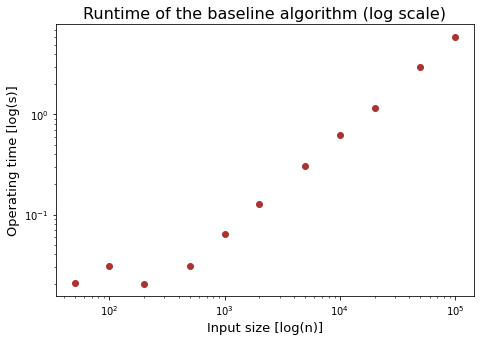

In [ ]:
wow = plt.figure(figsize=(7.5, 5))
plt.scatter(x = limits, y=runtimes, color = '#AB3334')
plt.title('Runtime of the baseline algorithm (log scale)', fontsize = 16)
plt.ylabel('Operating time [log(s)]', fontsize = 13)
plt.xlabel('Input size [log(n)]', fontsize = 13)
plt.xscale("log")
plt.yscale('log')
plt.show();

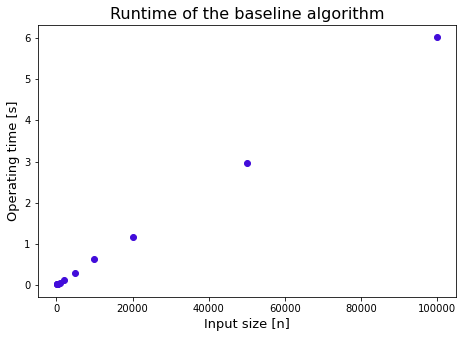

In [ ]:
wow2 = plt.figure(figsize=(7.5, 5))
plt.scatter(x = limits, y=runtimes, color = '#420CDA')
plt.title('Runtime of the baseline algorithm', fontsize = 16)
plt.ylabel('Operating time [s]', fontsize = 13)
plt.xlabel('Input size [n]', fontsize = 13)
plt.show();

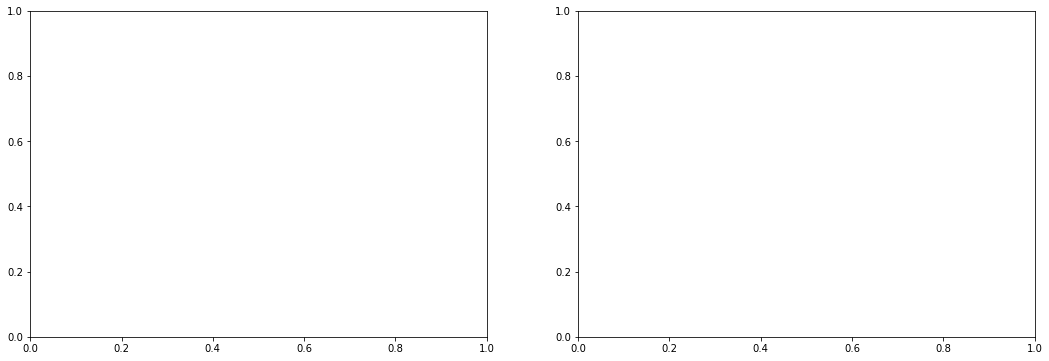

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

In [ ]:
ax1.scatter(x = limits, y=runtimes, color = '#420CDA')
ax1.set_title('Runtime of the baseline algorithm', fontsize = 16)
ax1.set_xlabel('Input size [n]', fontsize = 13)
ax1.set_ylabel('Operating time [s]', fontsize = 13)

ax2.scatter(x = limits, y=runtimes, color = '#AB3334')
ax2.set_title('Runtime of the baseline algorithm (log scale)', fontsize = 16)
ax2.set_ylabel('Operating time [log(s)]', fontsize = 13)
ax2.set_xlabel('Input size [log(n)]', fontsize = 13)
ax2.set_xscale("log")
ax2.set_yscale('log')

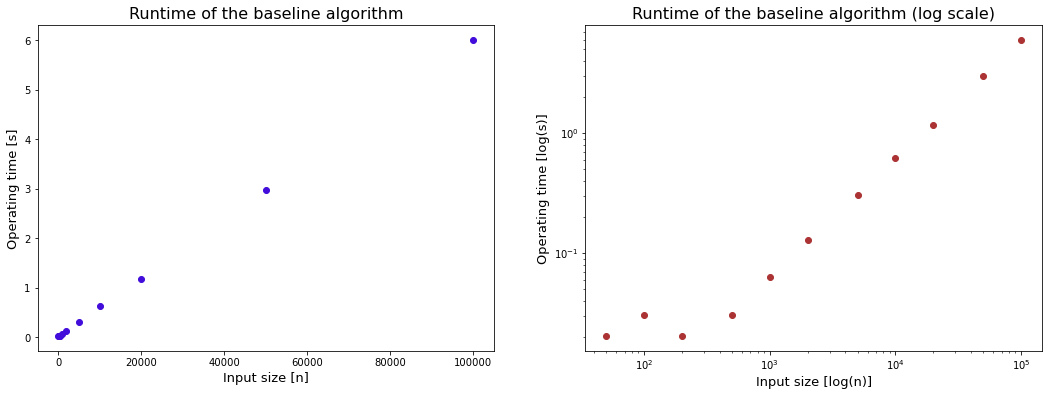

In [ ]:
f